## 1. Set up communication with the FR3

### 1.1 Set up communication with the arm

In [1]:
%load_ext autoreload
%autoreload 2
import sys 
from FR3Py.robot.interface import FR3Real
robot = FR3Real(robot_id='fr3')

Interface Running...


In [2]:
# Print the arm state
robot.getJointStates()

{'q': array([ 7.20597975e-04, -7.84720396e-01,  2.86792980e-04, -2.35597345e+00,
         6.72882415e-04,  1.57114048e+00,  7.84918573e-01]),
 'dq': array([-6.05203587e-04, -2.22595737e-04,  2.18287203e-04,  5.75445679e-06,
         3.54091411e-04,  2.87853852e-04,  1.75911721e-04]),
 'T': array([-0.11178899, -4.39721823, -0.72402036, 22.94101334,  0.67399824,
         2.11484504,  0.1268256 ]),
 'M': array([[ 4.93210072e-01, -9.14834068e-03,  4.91578980e-01,
         -1.17950473e-02,  6.15759797e-02, -3.07076350e-03,
          1.29280006e-03],
        [-9.14834068e-03,  1.54931631e+00,  4.68171005e-03,
         -7.02521209e-01, -1.29722412e-02, -2.24928174e-02,
         -1.54792050e-03],
        [ 4.91578980e-01,  4.68171005e-03,  9.96165670e-01,
         -2.58413563e-02,  7.51428537e-02, -3.85934726e-03,
          3.24994312e-03],
        [-1.17950473e-02, -7.02521209e-01, -2.58413563e-02,
          9.73361732e-01,  2.55906336e-02,  1.11776515e-01,
         -1.71185927e-04],
        

### 1.2 Set up communication with the gripper

In [4]:
from fr3_gripper import Gripper, GripperState
gripper = Gripper("192.168.123.250")

# Initialize the gripper
gripper.homing()

# Print the gripper state
gripper_state = gripper.readOnce()
print(gripper_state)

{'width': 0.023304443806409836, 'max_width': 0.08006539940834045, 'is_grasped': False, 'temperature': 52, 'time (ms)': 185}


## 2. Define robot task parameters

### 2.1 Load PinocchioModel and define various parameters

In [5]:
import numpy as np
from FR3Py.robot.model_collision_avoidance import PinocchioModel
import time

pin_robot = PinocchioModel()
joint_lb = np.array([-2.3093, -1.5133, -2.4937, -2.7478, -2.48, 0.8521, -2.6895])
joint_ub = np.array([2.3093, 1.5133, 2.4937, -0.4461, 2.48, 4.2094, 2.6895])
torque_lb = np.array([-87, -87, -87, -87, -12, -12, -12])
torque_ub = np.array([87, 87, 87, 87, 12, 12, 12])
joint_acc_lb = np.array([-10, -10, -10, -10, -10, -10, -10])
joint_acc_ub = np.array([10, 10, 10, 10, 10, 10, 10])
v_EE_lb = np.array([-0.15, -0.15, -0.15])
v_EE_ub = np.array([0.15, 0.15, 0.15])
static_friction = np.array([0.8, 2.0, 0.5, 2.0, 1.3, 1.0, 0.5])


n_joints = 7
n_controls = 7
q_bar = 0.5*(joint_ub + joint_lb)
delta_M = np.diag([0.2, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2])

ball_gravity = np.array([0, 0, -9.81, 0, 0, 0])*0.042


### 2.2 Define the obstacles using scaling functions and setup problems

In [6]:
# Obstacle parameters
obstacle_config = {
    "obs1":{
        "type": "polytope3d",
        "vertices": [[0.226, 0.293, 0.28], [0.234, 0.287, 0.28], [0.416, 0.543, 0.28], [0.424, 0.537, 0.28], [0.226, 0.293, 0.0], [0.234, 0.287, 0.0], [0.416, 0.543, 0.0], [0.424, 0.537, 0.0]],
        "pos": [0.0, 0.0, 0.0],
        "quat": [0.0, 0.0, 0.0, 1.0]
    },

    "obs2":{
        "type": "polytope3d",
        "vertices": [[0.417, 0.536, 0.28], [0.423, 0.544, 0.28], [0.047, 0.826, 0.28], [0.053, 0.834, 0.28], [0.417, 0.536, 0.0], [0.423, 0.544, 0.0], [0.047, 0.826, 0.0], [0.053, 0.834, 0.0]],
        "pos": [0.0, 0.0, 0.0],
        "quat": [0.0, 0.0, 0.0, 1.0]
    },

    "obs3":{
        "type": "polytope3d",
        "vertices": [[0.054, 0.827, 0.28], [0.046, 0.833, 0.28], [-0.136, 0.577, 0.28], [-0.144, 0.583, 0.28], [0.054, 0.827, 0.0], [0.046, 0.833, 0.0], [-0.136, 0.577, 0.0], [-0.144, 0.583, 0.0]],
        "pos": [0.0, 0.0, 0.0],
        "quat": [0.0, 0.0, 0.0, 1.0]
    },

    "obs4":{
        "type": "polytope3d",
        "vertices": [[-0.137, 0.584, 0.28], [-0.143, 0.576, 0.28], [0.233, 0.294, 0.28], [0.227, 0.286, 0.28], [-0.137, 0.584, 0.0], [-0.143, 0.576, 0.0], [0.233, 0.294, 0.0], [0.227, 0.286, 0.0]],
        "pos": [0.0, 0.0, 0.0],
        "quat": [0.0, 0.0, 0.0, 1.0]
    }

}

In [7]:
from cores.utils.bounding_shape_coef_mj import BoundingShapeCoef
from cores.obstacle_collections.polytope_collection import PolytopeCollection
import scalingFunctionsHelperPy as sfh
import HOCBFHelperPy as hh
from scipy.spatial.transform import Rotation
import multiprocessing
from liegroups import SO3
from cores.utils.proxsuite_utils import init_proxsuite_qp
from cores.utils.rotation_utils import get_quat_from_rot_matrix

# Load the bounding shape coefficients
BB_coefs = BoundingShapeCoef()
selected_BBs = ["HAND_BB", "LINK7_BB", "LINK6_BB"]
n_selected_BBs = len(selected_BBs)

# Obstacle
n_polytope = len(obstacle_config)
obs_col = PolytopeCollection(3, n_polytope, obstacle_config)

# CBF parameters
obstacle_kappa = 80

robot_SFs = []
for (i, bb_key) in enumerate(selected_BBs):
    ellipsoid_quadratic_coef = BB_coefs.coefs[bb_key]
    SF_rob = sfh.Ellipsoid3d(True, ellipsoid_quadratic_coef, np.zeros(3))
    robot_SFs.append(SF_rob)

polytope_SFs = []
for (i, obs_key) in enumerate(obs_col.face_equations.keys()):
    A_obs_np = obs_col.face_equations[obs_key]["A"]
    b_obs_np = obs_col.face_equations[obs_key]["b"]
    obs_kappa = obstacle_kappa
    SF_obs = sfh.LogSumExp3d(False, A_obs_np, b_obs_np, obs_kappa)
    polytope_SFs.append(SF_obs)
    
hyperplane_SFs = []
SF_hyperplane = sfh.Hyperplane3d(False, np.array([0,0,1]), 0.0)
hyperplane_SFs.append(SF_hyperplane)

# Create the problem collection
n_threads = min(max(multiprocessing.cpu_count() -1, 1), 10)
probs = hh.Problem3dCollection(n_threads)
for i in range(len(selected_BBs)):
    SF_rob = robot_SFs[i]
    frame_id = i
    for (j, obs_key) in enumerate(obs_col.face_equations.keys()):
        SF_obs = polytope_SFs[j]
        vertices = obs_col.face_equations[obs_key]["vertices_in_world"]
        prob = hh.EllipsoidAndLogSumExp3dPrb(SF_rob, SF_obs, vertices)
        probs.addProblem(prob, frame_id)

    for j in range(len(hyperplane_SFs)):
        SF_obs = hyperplane_SFs[j]
        prob = hh.EllipsoidAndHyperplane3dPrb(SF_rob, SF_obs)
        probs.addProblem(prob, frame_id)


/workspaces/HOCBF-FR3-Experiments/cores/obstacle_collections/polytope_collection.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='single')


## 3. Control the arm to starting point

In [18]:
# Rotate link 1 to reach preparation configuration
T = 5
q_d = np.array([np.pi/3, -np.pi/4, 0, -np.pi/4*3, 0, np.pi/2 , np.pi/4])


Kp_joint = np.diag([1, 1, 1, 1, 4, 2, 1])*1.5e2
Kd_joint = np.diag([2, 2, 2, 2, 2, 2, 2])*1e2
t_start = time.time()
while time.time() - t_start < T:
    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)
    M = robot_info['M'] + delta_M # shape (7,7)
    G = robot_info['G'] # shape (7,)
    Coriolis = robot_info['C'] # shape (7,)

    q_pin = 0.025*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)
    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]

    W = np.diag(1.0/(joint_ub-joint_lb))
    eq = W @ (q - q_d)
    deq = W @ dq
    ddq_nominal = - Kd_joint @ deq - Kp_joint @ eq

    ddq = ddq_nominal

    tau = M @ ddq + Coriolis + static_friction * np.tanh(dq)

    tau = np.clip(tau, torque_lb, torque_ub)
    robot.setCommands(tau)

robot.setCommands(np.zeros_like(tau))


## 4. Collision avoidance without circulation

### 4.1 Define the CBF-QP and various parameters

In [19]:
from cores.utils.trajectory_utils import PositionTrapezoidalTrajectory, OrientationTrapezoidalTrajectory

# Define proxuite problem
n_obstacle = n_polytope + 1
n_CBF = n_selected_BBs*n_obstacle
n_controls = 7
n_in = n_controls + n_CBF + 3
cbf_qp = init_proxsuite_qp(n_v=n_controls, n_eq=0, n_in=n_in)

# Define CBF parameters
alpha0 = 1.03
gamma1 = 20
gamma2 = 20
compensation = 0

# Define tracking gains
K_p_pos = np.diag([100,100,100])*0.9
K_d_pos = np.diag([50,50,50])*0.5

K_p_rot = np.diag([200,200,200])*1.8
K_d_rot = np.diag([100,100,100])*0.4

Kp_joint = 20*np.diag([1, 1, 1, 1, 1, 1, 1])
Kd_joint = 10*np.diag([1, 1, 1, 1, 1, 1, 1])

# Define the record
q_list = []
dq_list = []
ddq_list = []
tau_list = []
all_h_list = []
time_per_loop_list = []


### 4.2 Move from the starting point to pre-grasping pose 

In [20]:
t_final = 6

# Get current pose
robot_info = robot.getJointStates()
q = robot_info['q'] # shape (7,)
dq = robot_info['dq'] # shape (7,)

q_pin = 0.30*np.ones(9)
dq_pin = np.zeros(9)
q_pin[0:n_joints] = q # shape (9,)
dq_pin[0:n_joints] = dq # shape (9,)

pin_info = pin_robot.getInfo(q_pin, dq_pin)
P_EE = pin_info["P_EE"]
R_EE = pin_info["R_EE"]

# Translational trajectory
P_EE_start = P_EE.copy()
P_EE_pre_grasping = np.array([0.15, 0.62, 0.10])

via_points = np.array([P_EE_start, P_EE_pre_grasping])
target_time = np.array([0, t_final])
Ts = 0.01
traj_position = PositionTrapezoidalTrajectory(via_points, target_time, T_antp=0.2, Ts=Ts)

# Rotational trajectory
R_EE_start  = R_EE.copy()

roll = np.pi
pitch = 0
yaw = np.pi/3
R_EE_pre_grasping = Rotation.from_euler('xyz', [roll, pitch, yaw]).as_matrix()

orientations = np.array([R_EE_start, R_EE_pre_grasping])
target_time = np.array([0, t_final])
traj_orientation = OrientationTrapezoidalTrajectory(orientations, target_time, Ts=Ts)

t_start = time.time()
while time.time() - t_start < t_final + 1:
    time_loop_start = time.time()
    t = time.time() - t_start
    traj_pos, traj_pos_dt, traj_pos_dtdt = traj_position.get_traj_and_ders(t)
    traj_ori, traj_ori_dt, traj_ori_dtdt = traj_orientation.get_traj_and_ders(t)

    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)
    M = robot_info['M'] + delta_M # shape (7,7)
    G = robot_info['G'] # shape (7,)
    Coriolis = robot_info['C'] # shape (7,)

    q_pin = 0.025*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)

    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)

    # Primary obejctive: tracking control
    e_pos = P_EE - traj_pos # shape (3,)
    e_pos_dt = v_EE[:3] - traj_pos_dt # shape (3,)
    v_dt = traj_pos_dtdt - K_p_pos @ e_pos - K_d_pos @ e_pos_dt

    e_rot = SO3(R_EE @ traj_ori.T).log() # shape (3,)
    e_rot_dt = v_EE[3:] - traj_ori_dt # shape (3,)
    omega_dt = traj_ori_dtdt -K_p_rot @ e_rot - K_d_rot @ e_rot_dt

    v_EE_dt_desired = np.concatenate([v_dt, omega_dt])
    S = J_EE
    S_pinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    S_null = (np.eye(len(q)) - S_pinv @ S)
    ddq_task = S_pinv @ (v_EE_dt_desired - dJdq_EE)

    # Secondary objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    q_bar = 1/2*(joint_ub+joint_lb)
    e_joint = W @ (q - q_bar)
    e_joint_dot = W @ dq
    ddq_nominal = ddq_task + S_null @ (- Kp_joint @ e_joint - Kd_joint @ e_joint_dot)

    # CBF
    C = np.zeros([n_in, n_controls])
    lb = np.zeros(n_in)
    ub = np.zeros(n_in)
    CBF_tmp = np.zeros(n_CBF)
    phi1_tmp = np.zeros(n_CBF)
    phi2_tmp = np.zeros(n_CBF)

    all_P_np = np.zeros([n_selected_BBs, 3])
    all_quat_np = np.zeros([n_selected_BBs, 4])
    all_J_np = np.zeros([n_selected_BBs, 6, 7])
    all_dJdq_np = np.zeros([n_selected_BBs, 6])

    for (ii, bb_key) in enumerate(selected_BBs):
        all_P_np[ii, :] = pin_info["P_"+bb_key]
        all_J_np[ii, :, :] = pin_info["J_"+bb_key][:,:7]
        all_quat_np[ii, :] = get_quat_from_rot_matrix(pin_info["R_"+bb_key])
        all_dJdq_np[ii, :] = pin_info["dJdq_"+bb_key][:7]

    all_h_np, _, _, all_phi1_np, all_actuation_np, all_lb_np, all_ub_np = \
        probs.getCBFConstraints(dq, all_P_np, all_quat_np, all_J_np, all_dJdq_np, alpha0, gamma1, gamma2, compensation)
    
    # CBF-QP constraints
    C[0:n_CBF,:] = all_actuation_np
    lb[0:n_CBF] = all_lb_np
    ub[0:n_CBF] = all_ub_np
    CBF_tmp = all_h_np
    phi1_tmp = all_phi1_np

    g = -ddq_nominal

    C[n_CBF:n_CBF+n_controls,:] = np.eye(n_controls)
    lb[n_CBF:n_CBF+n_controls] = joint_acc_lb[:7]
    ub[n_CBF:n_CBF+n_controls] = joint_acc_ub[:7]

    h_v_lb = v_EE[0:3] - v_EE_lb
    h_v_ub = v_EE_ub - v_EE[0:3]
    C[n_CBF+n_controls:n_CBF+n_controls+3, :] = J_EE[0:3,:]
    lb[n_CBF+n_controls:n_CBF+n_controls+3] = -20*h_v_lb - dJdq_EE[0:3]
    ub[n_CBF+n_controls:n_CBF+n_controls+3] = 20*h_v_ub - dJdq_EE[0:3]

    cbf_qp.update(g=g, C=C, l=lb, u=ub)
    cbf_qp.solve()
    ddq = cbf_qp.results.x

    # ddq = ddq_nominal
    tau = M @ ddq + Coriolis + static_friction * np.tanh(dq)

    tau = np.clip(tau, -20, 20)
    robot.setCommands(tau)
    time_loop_end = time.time()

    q_list.append(q.copy())
    dq_list.append(dq.copy())
    ddq_list.append(ddq.copy())
    tau_list.append(tau.copy())
    all_h_list.append(all_h_np.copy())
    time_per_loop_list.append(time_loop_end - time_loop_start)

robot.setCommands(np.zeros_like(tau))


### 4.3 Grasp the object

In [21]:
t_final = 2

# Get current pose
robot_info = robot.getJointStates()
q = robot_info['q'] # shape (7,)
dq = robot_info['dq'] # shape (7,)

q_pin = 0.30*np.ones(9)
dq_pin = np.zeros(9)
q_pin[0:n_joints] = q # shape (9,)
dq_pin[0:n_joints] = dq # shape (9,)

pin_info = pin_robot.getInfo(q_pin, dq_pin)
P_EE = pin_info["P_EE"]
R_EE = pin_info["R_EE"]

# Translational trajectory
P_EE_start = P_EE.copy()
P_EE_grasping = np.array([0.15, 0.62, 0.02])

via_points = np.array([P_EE_start, P_EE_grasping])
target_time = np.array([0, t_final])
Ts = 0.01
traj_position = PositionTrapezoidalTrajectory(via_points, target_time, T_antp=0.2, Ts=Ts)

# Rotational trajectory
R_EE_start  = R_EE.copy()

roll = np.pi
pitch = 0
yaw = np.pi/3
R_EE_pre_grasping = Rotation.from_euler('xyz', [roll, pitch, yaw]).as_matrix()

orientations = np.array([R_EE_start, R_EE_pre_grasping])
target_time = np.array([0, t_final])
traj_orientation = OrientationTrapezoidalTrajectory(orientations, target_time, Ts=Ts)

t_start = time.time()
while time.time() - t_start < t_final + 1:
    time_loop_start = time.time()
    t = time.time() - t_start
    traj_pos, traj_pos_dt, traj_pos_dtdt = traj_position.get_traj_and_ders(t)
    traj_ori, traj_ori_dt, traj_ori_dtdt = traj_orientation.get_traj_and_ders(t)

    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)
    M = robot_info['M'] + delta_M # shape (7,7)
    G = robot_info['G'] # shape (7,)
    Coriolis = robot_info['C'] # shape (7,)

    q_pin = 0.025*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)

    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)

    # Primary obejctive: tracking control
    e_pos = P_EE - traj_pos # shape (3,)
    e_pos_dt = v_EE[:3] - traj_pos_dt # shape (3,)
    v_dt = traj_pos_dtdt - K_p_pos @ e_pos - K_d_pos @ e_pos_dt

    e_rot = SO3(R_EE @ traj_ori.T).log() # shape (3,)
    e_rot_dt = v_EE[3:] - traj_ori_dt # shape (3,)
    omega_dt = traj_ori_dtdt -K_p_rot @ e_rot - K_d_rot @ e_rot_dt

    v_EE_dt_desired = np.concatenate([v_dt, omega_dt])
    S = J_EE
    S_pinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    S_null = (np.eye(len(q)) - S_pinv @ S)
    ddq_task = S_pinv @ (v_EE_dt_desired - dJdq_EE)

    # Secondary objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    q_bar = 1/2*(joint_ub+joint_lb)
    e_joint = W @ (q - q_bar)
    e_joint_dot = W @ dq
    ddq_nominal = ddq_task + S_null @ (- Kp_joint @ e_joint - Kd_joint @ e_joint_dot)

    # CBF
    C = np.zeros([n_in, n_controls])
    lb = np.zeros(n_in)
    ub = np.zeros(n_in)
    CBF_tmp = np.zeros(n_CBF)
    phi1_tmp = np.zeros(n_CBF)
    phi2_tmp = np.zeros(n_CBF)

    all_P_np = np.zeros([n_selected_BBs, 3])
    all_quat_np = np.zeros([n_selected_BBs, 4])
    all_J_np = np.zeros([n_selected_BBs, 6, 7])
    all_dJdq_np = np.zeros([n_selected_BBs, 6])

    for (ii, bb_key) in enumerate(selected_BBs):
        all_P_np[ii, :] = pin_info["P_"+bb_key]
        all_J_np[ii, :, :] = pin_info["J_"+bb_key][:,:7]
        all_quat_np[ii, :] = get_quat_from_rot_matrix(pin_info["R_"+bb_key])
        all_dJdq_np[ii, :] = pin_info["dJdq_"+bb_key][:7]

    all_h_np, _, _, all_phi1_np, all_actuation_np, all_lb_np, all_ub_np = \
        probs.getCBFConstraints(dq, all_P_np, all_quat_np, all_J_np, all_dJdq_np, alpha0, gamma1, gamma2, compensation)
    
    # CBF-QP constraints
    C[0:n_CBF,:] = all_actuation_np
    lb[0:n_CBF] = all_lb_np
    ub[0:n_CBF] = all_ub_np
    CBF_tmp = all_h_np
    phi1_tmp = all_phi1_np

    g = -ddq_nominal

    C[n_CBF:n_CBF+n_controls,:] = np.eye(n_controls)
    lb[n_CBF:n_CBF+n_controls] = joint_acc_lb[:7]
    ub[n_CBF:n_CBF+n_controls] = joint_acc_ub[:7]

    h_v_lb = v_EE[0:3] - v_EE_lb
    h_v_ub = v_EE_ub - v_EE[0:3]
    C[n_CBF+n_controls:n_CBF+n_controls+3, :] = J_EE[0:3,:]
    lb[n_CBF+n_controls:n_CBF+n_controls+3] = -20*h_v_lb - dJdq_EE[0:3]
    ub[n_CBF+n_controls:n_CBF+n_controls+3] = 20*h_v_ub - dJdq_EE[0:3]

    cbf_qp.update(g=g, C=C, l=lb, u=ub)
    cbf_qp.solve()
    ddq = cbf_qp.results.x

    # ddq = ddq_nominal
    tau = M @ ddq + Coriolis + static_friction * np.tanh(dq)

    tau = np.clip(tau, -20, 20)
    robot.setCommands(tau)
    time_loop_end = time.time()

    q_list.append(q.copy())
    dq_list.append(dq.copy())
    ddq_list.append(ddq.copy())
    tau_list.append(tau.copy())
    all_h_list.append(all_h_np.copy())
    time_per_loop_list.append(time_loop_end - time_loop_start)

robot.setCommands(np.zeros_like(tau))

# Grasp the object
gripper_width = 0.04  # m
speed = 0.05  # m / s
force = 10  # N
epsilon_inner = 0.01  # m
epsilon_outer = 0.01  # m
gripper.grasp(gripper_width, speed, force, epsilon_inner, epsilon_outer)


True

### 4.4 Move out of the box

In [22]:
t_1 = 2
t_2 = 12
t_final = 22

# Get current pose
robot_info = robot.getJointStates()
q = robot_info['q'] # shape (7,)
dq = robot_info['dq'] # shape (7,)

q_pin = 0.30*np.ones(9)
dq_pin = np.zeros(9)
q_pin[0:n_joints] = q # shape (9,)
dq_pin[0:n_joints] = dq # shape (9,)

pin_info = pin_robot.getInfo(q_pin, dq_pin)
P_EE = pin_info["P_EE"]
R_EE = pin_info["R_EE"]

# Translational trajectory
P_EE_start = P_EE.copy()
P_EE_pre_grasping = np.array([0.15, 0.64, 0.10])
P_EE_end = np.array([0.50, 0.25, 0.08])

via_points = np.array([P_EE_start, P_EE_pre_grasping, P_EE_end, P_EE_end])
target_time = np.array([0, t_1, t_2, t_final])
Ts = 0.01
traj_position = PositionTrapezoidalTrajectory(via_points, target_time, T_antp=0.2, Ts=Ts)

# Rotational trajectory
R_EE_start  = R_EE.copy()

roll = np.pi
pitch = 0
yaw = np.pi/3
R_EE_pre_grasping = Rotation.from_euler('xyz', [roll, pitch, yaw]).as_matrix()

roll = np.pi
pitch = 0
yaw = np.pi/3
R_EE_end = Rotation.from_euler('xyz', [roll, pitch, yaw]).as_matrix()

orientations = np.array([R_EE_start, R_EE_pre_grasping, R_EE_end, R_EE_end])
target_time = np.array([0, t_1, t_2, t_final])
traj_orientation = OrientationTrapezoidalTrajectory(orientations, target_time, Ts=Ts)

t_start = time.time()
while time.time() - t_start < t_final + 1:
    time_loop_start = time.time()
    t = time.time() - t_start
    traj_pos, traj_pos_dt, traj_pos_dtdt = traj_position.get_traj_and_ders(t)
    traj_ori, traj_ori_dt, traj_ori_dtdt = traj_orientation.get_traj_and_ders(t)

    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)
    M = robot_info['M'] + delta_M # shape (7,7)
    G = robot_info['G'] # shape (7,)
    Coriolis = robot_info['C'] # shape (7,)

    q_pin = 0.025*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)

    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)

    # Primary obejctive: tracking control
    e_pos = P_EE - traj_pos # shape (3,)
    e_pos_dt = v_EE[:3] - traj_pos_dt # shape (3,)
    v_dt = traj_pos_dtdt - K_p_pos @ e_pos - K_d_pos @ e_pos_dt

    e_rot = SO3(R_EE @ traj_ori.T).log() # shape (3,)
    e_rot_dt = v_EE[3:] - traj_ori_dt # shape (3,)
    omega_dt = traj_ori_dtdt -K_p_rot @ e_rot - K_d_rot @ e_rot_dt

    v_EE_dt_desired = np.concatenate([v_dt, omega_dt])
    S = J_EE
    S_pinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    S_null = (np.eye(len(q)) - S_pinv @ S)
    ddq_task = S_pinv @ (v_EE_dt_desired - dJdq_EE)

    # Secondary objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    q_bar = 1/2*(joint_ub+joint_lb)
    e_joint = W @ (q - q_bar)
    e_joint_dot = W @ dq
    ddq_nominal = ddq_task + S_null @ (- Kp_joint @ e_joint - Kd_joint @ e_joint_dot)

    # CBF
    C = np.zeros([n_in, n_controls])
    lb = np.zeros(n_in)
    ub = np.zeros(n_in)
    CBF_tmp = np.zeros(n_CBF)
    phi1_tmp = np.zeros(n_CBF)
    phi2_tmp = np.zeros(n_CBF)

    all_P_np = np.zeros([n_selected_BBs, 3])
    all_quat_np = np.zeros([n_selected_BBs, 4])
    all_J_np = np.zeros([n_selected_BBs, 6, 7])
    all_dJdq_np = np.zeros([n_selected_BBs, 6])

    for (ii, bb_key) in enumerate(selected_BBs):
        all_P_np[ii, :] = pin_info["P_"+bb_key]
        all_J_np[ii, :, :] = pin_info["J_"+bb_key][:,:7]
        all_quat_np[ii, :] = get_quat_from_rot_matrix(pin_info["R_"+bb_key])
        all_dJdq_np[ii, :] = pin_info["dJdq_"+bb_key][:7]

    all_h_np, _, _, all_phi1_np, all_actuation_np, all_lb_np, all_ub_np = \
        probs.getCBFConstraints(dq, all_P_np, all_quat_np, all_J_np, all_dJdq_np, alpha0, gamma1, gamma2, compensation)
    
    # CBF-QP constraints
    C[0:n_CBF,:] = all_actuation_np
    lb[0:n_CBF] = all_lb_np
    ub[0:n_CBF] = all_ub_np
    CBF_tmp = all_h_np
    phi1_tmp = all_phi1_np

    g = -ddq_nominal

    C[n_CBF:n_CBF+n_controls,:] = np.eye(n_controls)
    lb[n_CBF:n_CBF+n_controls] = joint_acc_lb[:7]
    ub[n_CBF:n_CBF+n_controls] = joint_acc_ub[:7]

    h_v_lb = v_EE[0:3] - v_EE_lb
    h_v_ub = v_EE_ub - v_EE[0:3]
    C[n_CBF+n_controls:n_CBF+n_controls+3, :] = J_EE[0:3,:]
    lb[n_CBF+n_controls:n_CBF+n_controls+3] = -20*h_v_lb - dJdq_EE[0:3]
    ub[n_CBF+n_controls:n_CBF+n_controls+3] = 20*h_v_ub - dJdq_EE[0:3]

    cbf_qp.update(g=g, C=C, l=lb, u=ub)
    cbf_qp.solve()
    ddq = cbf_qp.results.x

    # ddq = ddq_nominal
    tau = M @ ddq + Coriolis + static_friction * np.tanh(dq) + J_EE.T @ ball_gravity

    tau = np.clip(tau, -20, 20)
    robot.setCommands(tau)
    time_loop_end = time.time()

    q_list.append(q.copy())
    dq_list.append(dq.copy())
    ddq_list.append(ddq.copy())
    tau_list.append(tau.copy())
    all_h_list.append(all_h_np.copy())
    time_per_loop_list.append(time_loop_end - time_loop_start)


### 4.5 Drop the object

In [23]:
robot.setCommands(np.zeros_like(tau))
gripper_width = 0.08
speed = 0.05
gripper.move(gripper_width, speed)

True

## 5. Save the data

In [24]:
import pickle
from datetime import datetime
import os

now = datetime.now()
formatted_date_time = now.strftime("%Y-%m-%d-%H-%M-%S")

directory = f"exp1_results/no_circ_{formatted_date_time}"

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the file path
file_path = os.path.join(directory, "data.pickle")

# Data to be saved
data = {
    "q": q_list,
    "dq": dq_list,
    "ddq": ddq_list,
    "tau": tau_list,
    "all_h": all_h_list,
    "time_per_loop": time_per_loop_list
}

# Save the data using pickle
with open(file_path, "wb") as f:
    pickle.dump(data, f)



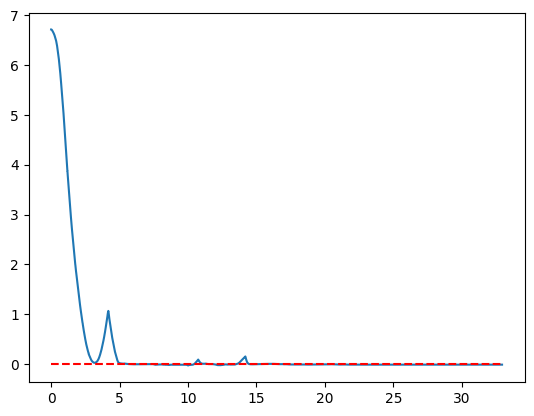

In [25]:
import matplotlib.pyplot as plt

t = np.cumsum(time_per_loop_list)
all_h = np.array(all_h_list)
plt.plot(t, np.min(all_h, axis = 1))
plt.hlines(0, t[0], t[-1], colors='r', linestyles='dashed')